In [2]:
import numpy as np
import pandas as pd

import librosa
import librosa.display as ld

import glob

import matplotlib.pyplot as plt

/Users/sudheer/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/sudheer/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/sudheer/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Reading CSV that contains audio file to instrument label mapping.

In [3]:
df = pd.read_csv('instruments.csv')
df.head()

,fname,label
0,5388d14d.wav,Saxophone
1,c685f05f.wav,Saxophone
2,36d20ab5.wav,Saxophone
3,d6665734.wav,Saxophone
4,7352e28f.wav,Saxophone


Getting the distribution of recordings for each type of instrument

In [4]:
instrument_types = df['label'].value_counts()
print(instrument_types)

Snare_drum          30
Saxophone           30
Violin_or_fiddle    30
Flute               30
Hi-hat              30
Acoustic_guitar     30
Double_bass         30
Clarinet            30
Cello               30
Bass_drum           30
Name: label, dtype: int64


In [5]:
instruments = df['label'].unique()
instruments

array(['Saxophone', 'Violin_or_fiddle', 'Hi-hat', 'Snare_drum',
       'Acoustic_guitar', 'Double_bass', 'Cello', 'Bass_drum', 'Flute',
       'Clarinet'], dtype=object)

System-wide configuration such as sampling rate.

In [6]:
class Config:
    sr = 44100
    random_state = 42

Extracting a sample MFCC for each instrument type & plotting it.

In [7]:
def extract_mfcc(file):
    signal, sr = librosa.load(file, Config.sr)
    return librosa.feature.mfcc(y=signal, sr=sr)

In [8]:
mfccs = [extract_mfcc(f'wavfiles/{df[df.label == instrument].iloc[0,0]}') for instrument in instruments]

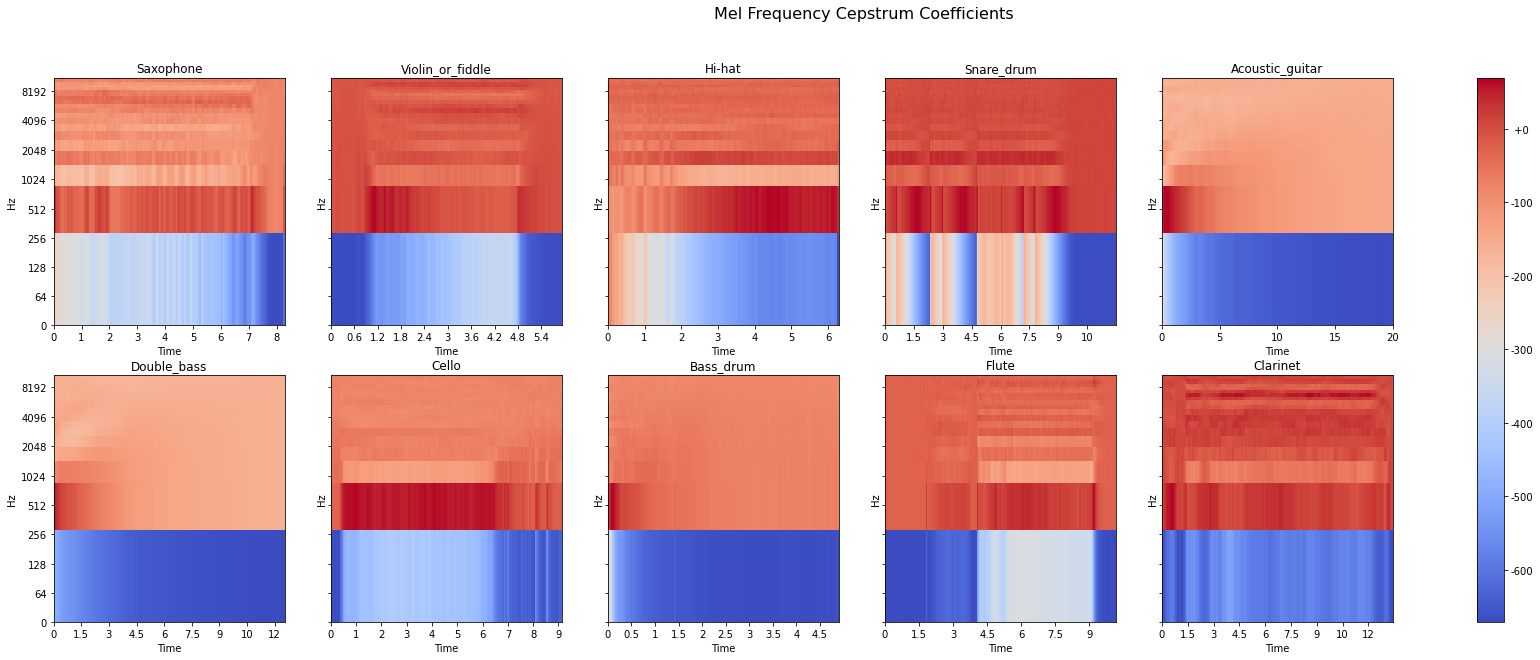

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(30,10))
fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
for i, instrument in enumerate(instruments):
    row = 0 if i < 5 else 1
    col = i % 5
    axis = ax[row, col]
    axis.set(title = f'{instrument}')
    axis.get_xaxis().set_visible(True)
    axis.get_yaxis().set_visible(True)
    i = librosa.display.specshow(mfccs[i], x_axis='time', y_axis='log', ax=ax[row, col])#, cmap='Blues'
plt.colorbar(i, ax=ax, format='%+3.f')

Classifier class with ability to configure no. of samples and features used for classification.

Internally uses Naive Bayes as the baseline followed by SVM for better performance.

In [20]:
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.naive_bayes import GaussianNB

class InstrumentClassifier:
    def __init__(self, n_samples, feature = 'mfcc', model='gnb'):
        self.n_samples = n_samples
        self.feature = feature
        self.model = model

        if 'gnb' == model:
            self.pipeline = Pipeline([
                ('Standard Scaler', StandardScaler()),
                ('PCA', PCA(n_components = 10)),
                ('Gaussian Naive Bayes', GaussianNB())
            ])
        
        if 'svc' == model:
            self.pipeline = Pipeline([
                ('Standard Scaler', StandardScaler()),
                ('PCA', PCA(n_components = 10)),
                ('SVM', svm.SVC(gamma = 'auto'))
            ])

    def _extract(self, row):
        signal, sr = librosa.load(f'wavfiles/{row[0]}', Config.sr)
        if 'mfcc' in self.feature:
            X = row['mfcc']
        if 'melspectrogram' in self.feature:
            X = row['melspectrogram']
        X_y = np.append(X, row[1])
        return X_y

    def _extract_X_y(self, df):
        samples = df.sample(n=self.n_samples, replace=True, random_state=Config.random_state)
        data = samples.apply(self._extract, axis=1, result_type='expand')
        X = data.iloc[:,:-1]
        y = data.iloc[:,-1]
        return X, y

    def extract_features(self, df):
        self.X, self.y = self._extract_X_y(df)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.25, random_state=Config.random_state)

    def fit(self):
        self.pipeline.fit(self.x_train, self.y_train)
    
    def perf(self):
        return self.pipeline.score(self.x_test, self.y_test)
    
    def predict(self):
        self.y_pred = self.pipeline.predict(self.x_test)


In [11]:
def _extract_mfcc(signal, sr):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr)
    aver = np.mean(mfccs, axis = 1)
    feature = aver.reshape(20)
    return feature

def _extract_melspectrogram(signal, sr):
    spectrogram = librosa.feature.melspectrogram(signal)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    spectrogram = np.mean(spectrogram, axis=1)
    return spectrogram

def extract(row):
    signal, sr = librosa.load(f'wavfiles/{row[0]}', Config.sr)
    x1 = _extract_mfcc(signal, sr)
    x2 = _extract_melspectrogram(signal, sr)
    return x1,x2

df['mfcc'], df['melspectrogram'] = zip(*df.apply(extract, axis=1))
df.iloc[:5,:]

,fname,label,mfcc,melspectrogram
0,5388d14d.wav,Saxophone,"(-272.33786, 58.306755, -47.943787, 7.301422, ...","(-2.7999992, -25.17658, -28.684496, -28.723795..."
1,c685f05f.wav,Saxophone,"(-287.33243, 101.56712, -29.987404, 20.03815, ...","(2.3896997, -17.04163, -16.49534, -13.215973, ..."
2,36d20ab5.wav,Saxophone,"(-238.68503, 153.41728, -26.39078, 26.09202, 1...","(-9.527214, -15.543957, 10.565876, 24.367052, ..."
3,d6665734.wav,Saxophone,"(-351.35153, 166.21623, -41.64548, 4.0183616, ...","(-33.780457, -23.965872, -6.249142, 3.50676, 5..."
4,7352e28f.wav,Saxophone,"(-315.89813, 146.70885, -78.09529, -38.58948, ...","(-33.47275, -35.72336, -40.216938, -40.49374, ..."


Testing the classifier with different audio features & sample sizes.

In [21]:
import pandas as pd

samples = [300, 600, 1000, 2000]
scores_dict = {}

dfRes = pd.DataFrame(columns=['Feature', 'Model', 'Sample', 'Accuracy'])


for sample in samples:
    for feature in ['mfcc', 'melspectrogram']:
        for model in ['gnb', 'svc']:
            classifier = InstrumentClassifier(sample, feature = feature, model=model)
            classifier.extract_features(df)
            classifier.fit()
            score = classifier.perf()
            dfRes = dfRes.append({'Feature':classifier.feature, 'Model':classifier.model, 'Sample':classifier.n_samples, 'Accuracy':score}, ignore_index=True)

In [22]:
dfRes\
    .sort_values(by=['Model', 'Feature', 'Sample'])\
    .pivot(index=['Sample'], columns=['Model', 'Feature'],values=['Accuracy'])

Accuracy                                   
Model              gnb                      svc          
Feature melspectrogram      mfcc melspectrogram      mfcc
Sample                                                   
300           0.546667  0.533333       0.720000  0.706667
600           0.573333  0.700000       0.926667  0.933333
1000          0.628000  0.712000       0.912000  0.916000
2000          0.634000  0.666000       0.966000  0.942000

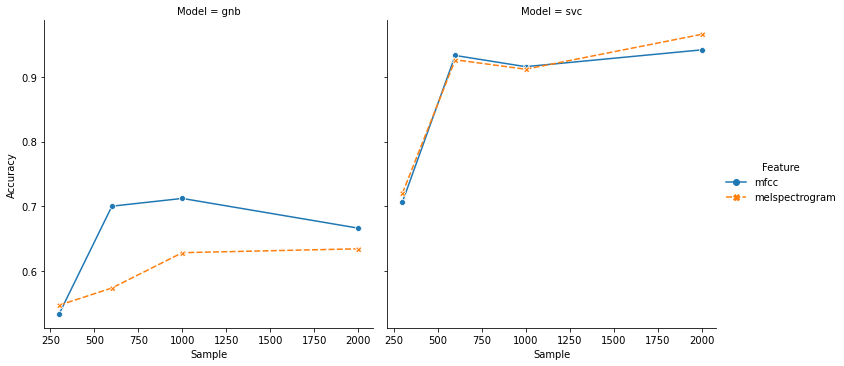

In [23]:
import seaborn as sns

sns.relplot(data=dfRes, x="Sample", y="Accuracy", hue="Feature", style="Feature", col="Model", kind="line", markers=True)

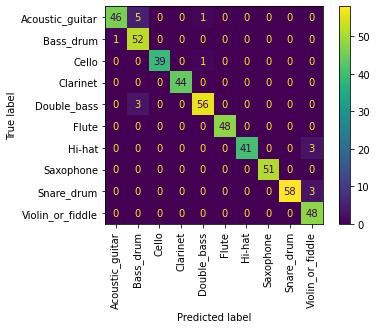

In [25]:
from sklearn.metrics import plot_confusion_matrix

classifier = InstrumentClassifier(2000, feature = 'melspectrogram', model='svc')
classifier.extract_features(df)
classifier.fit()
plot_confusion_matrix(classifier.pipeline, classifier.x_test, classifier.y_test, xticks_rotation='vertical')  
plt.show()  

In [29]:
from sklearn.metrics import classification_report

classifier.predict()
report = classification_report(classifier.y_test, classifier.y_pred)
print(report)

                  precision    recall  f1-score   support

 Acoustic_guitar       0.98      0.88      0.93        52
       Bass_drum       0.87      0.98      0.92        53
           Cello       1.00      0.97      0.99        40
        Clarinet       1.00      1.00      1.00        44
     Double_bass       0.97      0.95      0.96        59
           Flute       1.00      1.00      1.00        48
          Hi-hat       1.00      0.93      0.96        44
       Saxophone       1.00      1.00      1.00        51
      Snare_drum       1.00      0.95      0.97        61
Violin_or_fiddle       0.89      1.00      0.94        48

        accuracy                           0.97       500
       macro avg       0.97      0.97      0.97       500
    weighted avg       0.97      0.97      0.97       500

